In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

In [20]:
print("Downloading S&P 500 data...")
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
print(f"Data shape: {sp500.shape}")

Data shape: (24560, 7)


<Axes: xlabel='Date'>

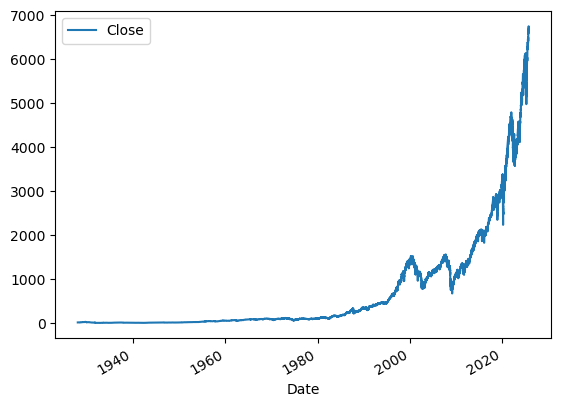

In [21]:
sp500.plot.line(y="Close", use_index=True)

In [22]:
# Remove unnecessary columns
del sp500["Dividends"]
del sp500["Stock Splits"]

# Create target variable (EXACTLY as in original)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Focus on modern data (post-1990)
sp500 = sp500.loc["1990-01-01":].copy()
print(f"Filtered data shape: {sp500.shape}")

Filtered data shape: (9010, 7)


In [28]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-02 00:00:00-04:00,6731.310059,6731.939941,6693.229980,6715.350098,5416130000,6715.790039,1,1.000309,2.0,1.004693,5.0,1.040123,35.0,1.118844,142.0,1.377728,531.0
2025-10-03 00:00:00-04:00,6722.140137,6750.870117,6705.669922,6715.790039,5713110000,6740.279785,1,1.000033,2.0,1.002596,5.0,1.039023,35.0,1.118160,143.0,1.377161,532.0
2025-10-06 00:00:00-04:00,6733.859863,6749.520020,6717.779785,6740.279785,5604460000,6714.589844,0,1.001820,2.0,1.003882,5.0,1.041522,36.0,1.121499,143.0,1.381509,533.0


In [23]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Create rolling averages and trends
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

# Remove rows with NaN values
sp500 = sp500.dropna()

In [24]:
def predict(train, test, predictors, model):

    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    
    # CRITICAL: Use exact same threshold logic as original
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):

    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)


In [27]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.54656
0    0.45344
Name: count, dtype: float64

In [25]:
model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=50,
    random_state=1
)

# Run backtest with ONLY new_predictors (as in Cell 47)
print("\nRunning backtest...")
predictions = backtest(sp500, model, new_predictors)

# Calculate metrics
precision = precision_score(predictions["Target"], predictions["Predictions"])
prediction_counts = predictions["Predictions"].value_counts()

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"Precision Score: {precision:.4f} ({precision*100:.2f}%)")
print("\nPrediction Distribution:")
print(f"  Down (0): {prediction_counts.get(0.0, 0)}")
print(f"  Up (1): {prediction_counts.get(1.0, 0)}")
print(f"\nBaseline (actual market up frequency): {predictions['Target'].mean():.4f}")



Running backtest...

RESULTS
Precision Score: 0.5747 (57.47%)

Prediction Distribution:
  Down (0): 4639
  Up (1): 870

Baseline (actual market up frequency): 0.5466
